In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Optional, Sequence
from coba.experiments.results import CustomResult
import numpy as np

from coba import CobaRandom, Environments, RandomLearner, Experiment, VowpalSoftmaxLearner, VowpalBagLearner, \
    VowpalEpsilonLearner, SimpleEvaluation
from coba import VowpalCoverLearner, VowpalRegcbLearner, VowpalSquarecbLearner, VowpalOffPolicyLearner, CorralLearner
from coba.environments import LambdaSimulation
# from coba.experiments.tasks import SimpleEvaluation
from coba.primitives import Context, Action

# Run Simulation

In [3]:
class CustomEnvironment(LambdaSimulation):
    def __init__(self, n_interactions: Optional[int] = 1000):
        super().__init__(n_interactions, self.context, self.actions, self.rewards)
        self.r = CobaRandom(1)

    def actions(self, index: int, context: Context) -> Sequence[Action]:
        """
        actions: A function that should return all valid actions for a given index, context and random state.
        """
        return [0, 1]

    def context(self, index: int) -> Context:
        return {
            "feature_1": self.r.randoms(1)[0],
            "feature_2": self.r.randoms(1)[0],
            "feature_3": self.r.randoms(1)[0]
        }

    def rewards(self, index: int, context: Context, action: Action) -> float:
        # reward centered around 0.5, with feature_1 strongly positively correlating with the reward for the first action 
        # and feature_2 half as much negatively correlating
        reward_probabilities_for_actions = [
            0.5 
                + 1.0 * (context["feature_1"] - 0.5) 
                - 0.5 * (context["feature_2"] - 0.5),
            0.5
        ]
        
        reward_probabilities_for_actions = [min(1.0, max(0.0, prob)) for prob in reward_probabilities_for_actions]
        return np.random.binomial(1, reward_probabilities_for_actions[action])

environments = Environments([CustomEnvironment(5000)]).shuffle(n=4)

learners = [
    VowpalSoftmaxLearner(features=[1, 'x', 'a', 'ax']),
]

learners.append(RandomLearner())

result = Experiment(
    environments,
    learners,
    evaluation_task=SimpleEvaluation(record=['reward','probability','action','context', 'ope_loss', 'rewards'])
).run()
result.__class__ = CustomResult

2023-02-08 17:04:36 -- pid-27245  -- Processing chunk...
2023-02-08 17:04:36 -- pid-27245  --   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2023-02-08 17:04:36 -- pid-27245  --   * Recording Learner 1 parameters... (0.0 seconds) (completed)
2023-02-08 17:04:36 -- pid-27245  --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2023-02-08 17:04:36 -- pid-27245  --   * Peeking at Environment 0... (0.03 seconds) (completed)
2023-02-08 17:04:37 -- pid-27245  --   * Evaluating Learner 0 on Environment 0... (0.24 seconds) (completed)
2023-02-08 17:04:37 -- pid-27245  --   * Peeking at Environment 0... (0.02 seconds) (completed)
2023-02-08 17:04:37 -- pid-27245  --   * Evaluating Learner 1 on Environment 0... (0.07 seconds) (completed)
2023-02-08 17:04:37 -- pid-27245  --   * Recording Environment 1 statistics... (0.0 seconds) (completed)
2023-02-08 17:04:37 -- pid-27245  --   * Peeking at Environment 1... (0.02 seconds) (completed)
2023-02-08 17:04:37 -- pi

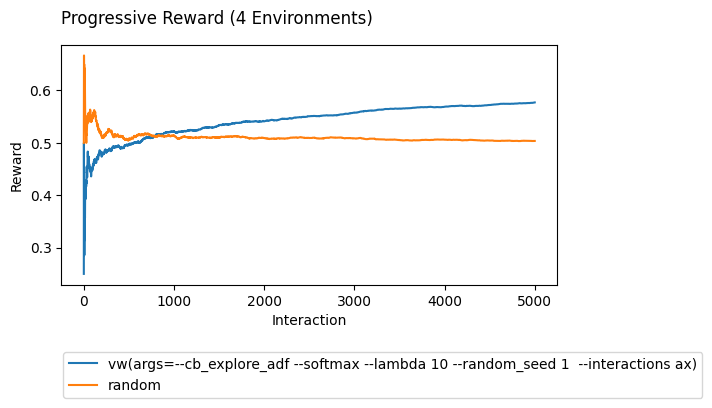

In [4]:
result.plot_learners()

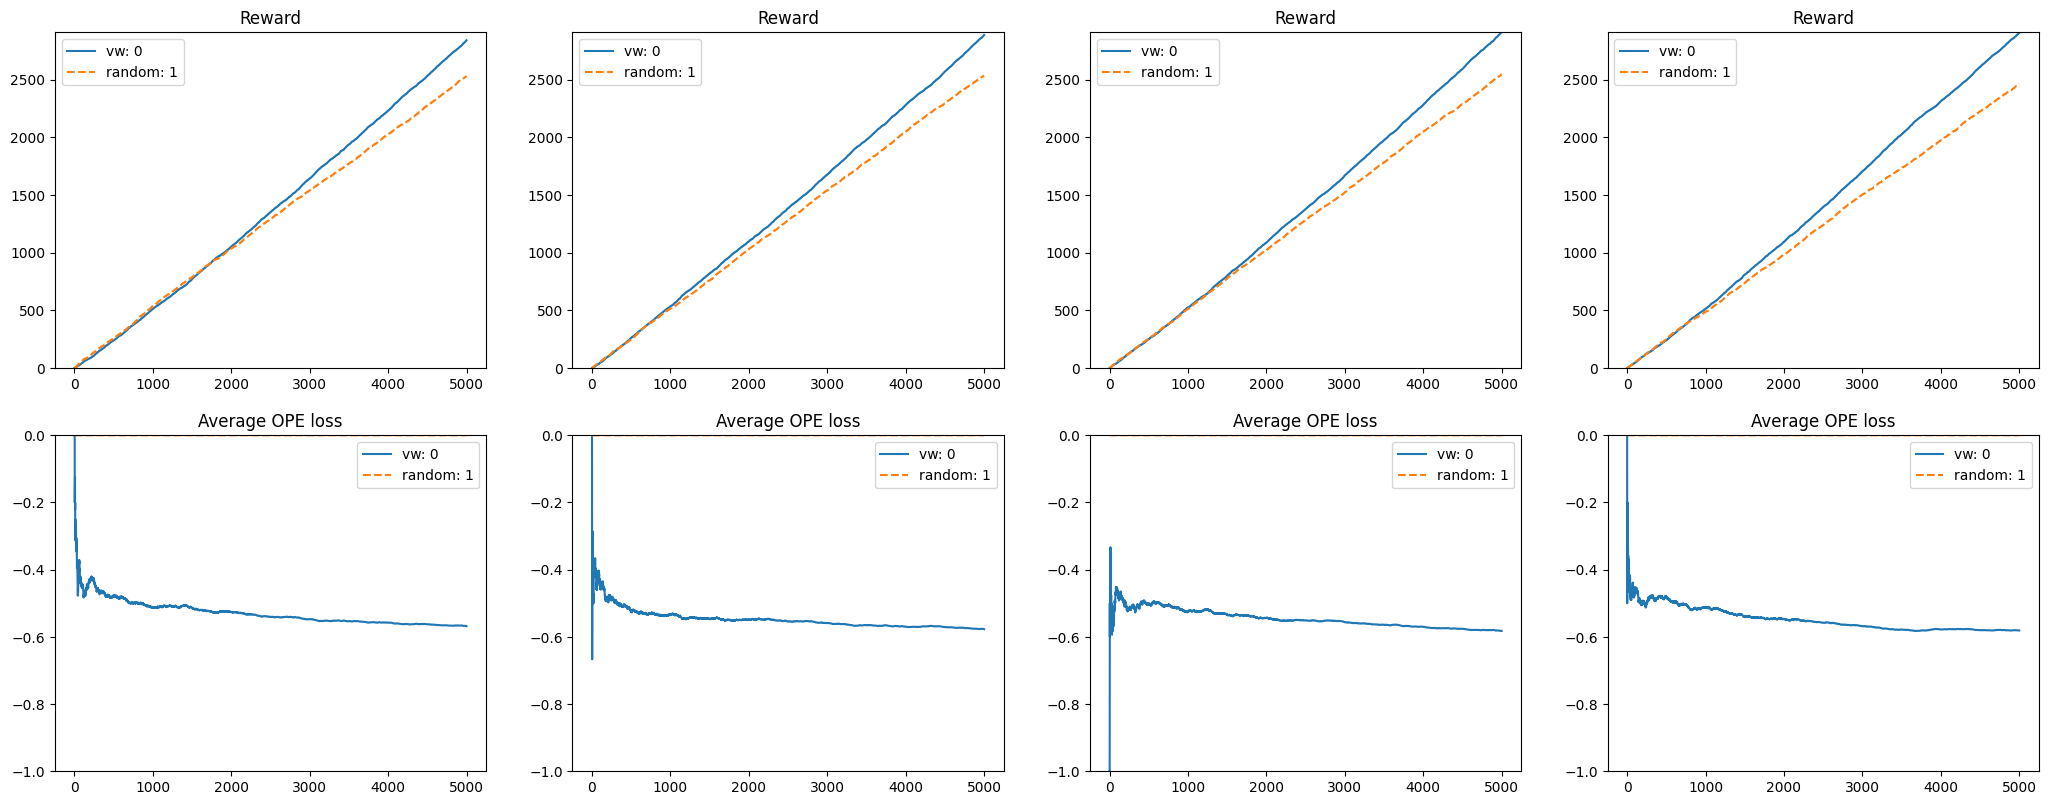

In [5]:
result.plot_overview(metrics = {'reward', 'average_ope_loss'})

In [6]:
result.eval_metrics()

,learners,reward,action,probability,ope_loss,environment_variance
learner_id,,,,,,
0,vw: --cb_explore_adf --softmax --lambda 10 --r...,0.5771,0.4483,0.731361,-0.069846,0.000041
1,random: N/A,0.5036,0.4912,0.500000,0.000000,0.000058


array([[<AxesSubplot: title={'center': 'action'}>]], dtype=object)

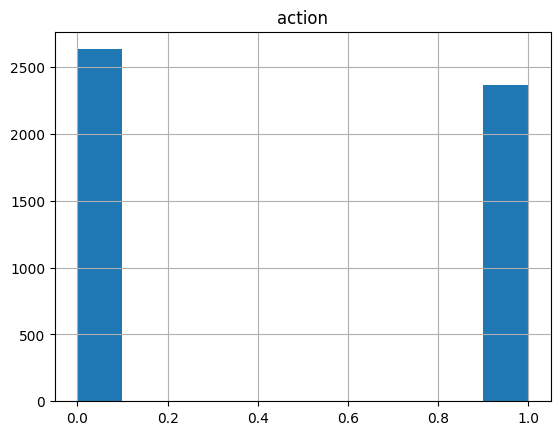

In [7]:
df = result.interactions.to_pandas()
df[:5000].hist(column='action')

In [8]:
df.rename(columns={"xxx": "rewards"}, inplace=True)

In [9]:
df

,environment_id,learner_id,index,reward,action,context,ope_loss,probability,rewards
0,0,0,1,0,0,"{'feature_1': 0.10863548330962658, 'feature_2'...",0.0,0.5,"[0, 0]"
1,0,0,2,0,1,"{'feature_1': 0.6377932336181402, 'feature_2':...",0.0,0.5,"[1, 0]"
2,0,0,3,0,0,"{'feature_1': 0.8407034799456596, 'feature_2':...",0.0,0.5,"[0, 1]"
3,0,0,4,0,0,"{'feature_1': 0.030388953164219856, 'feature_2...",0.0,0.5,"[0, 1]"
4,0,0,5,1,0,"{'feature_1': 0.2219219021499157, 'feature_2':...",-1.0,0.5,"[1, 1]"
...,...,...,...,...,...,...,...,...,...
39995,3,1,4996,0,1,"{'feature_1': 0.7417118372395635, 'feature_2':...",NaN,0.5,"[0, 0]"
39996,3,1,4997,0,0,"{'feature_1': 0.6868284521624446, 'feature_2':...",NaN,0.5,"[0, 0]"
39997,3,1,4998,1,1,"{'feature_1': 0.19236186798661947, 'feature_2'...",NaN,0.5,"[0, 1]"
39998,3,1,4999,1,1,"{'feature_1': 0.7434793943539262, 'feature_2':...",NaN,0.5,"[1, 1]"


In [10]:
df[:5000].to_csv('lambda_logs_x.csv')